# Homework 3

## FINM 36700 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

***

# 1. Modeling Volatility and VaR

## Data

Find the data file `spy_data.xlsx`.

* Use the returns on the S&P 500 (`SPY`) and 1-month T-bills (`^IRX`).

* Calculate the excess market returns, using the treasury rate as the risk-free rate.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import skew,kurtosis,norm


filename = r'C:\Users\josel\Documents\GitHub\finm-portfolio-2024\data\spy_data.xlsx'
# filename = r"C:\Users\josel\Downloads\multi_asset_etf_data (1).xlsx"
spy_data = pd.read_excel(filename,sheet_name="total returns",index_col=[0])

In [3]:
spy_data["SPY_Excess_Return"] = spy_data["SPY"] - spy_data["^IRX"]

<Axes: xlabel='date'>

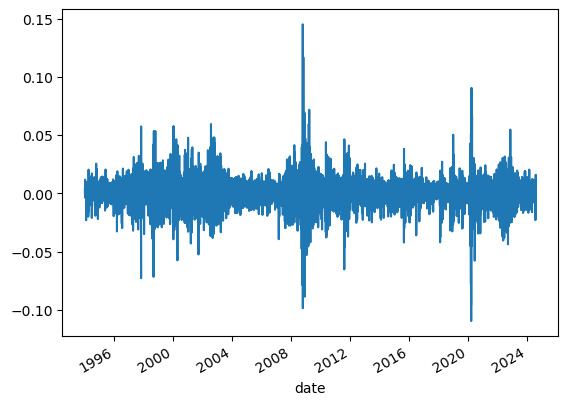

In [4]:
spy_data["SPY_Excess_Return"].plot()

***

## 1.1 Historic VaR.
Starting at `Jan 2, 2001`, calculate the historic-based VaR, based on the expanding sample from the first date through `Dec 29, 2000`. 

Denote $\tilde{r}^{VaR, 0.05}_{t}$ as the estimate of the time-t VaR based on data through $t − 1$.

### Report
Report the items below, starting at , starting at `Jan 2, 2001`.

* Plot $\tilde{r}^{VaR, 0.05}_{t}$ over time.

* Report the frequency of periods in which $\tilde{r} < \tilde{r}^{VaR, 0.05}_{t}$. Compare this to the quantile of $.05$.

* What drawbacks do you see in this historic VaR?

#### Note
By historic VaR, we mean simply taking the 5th quantile for the historic sample up to time $t − 1$. Of course, a sample size that is not a multiple of 100 will require some interpolation to get a 5th quantile. Your statistical package should handle this fine.

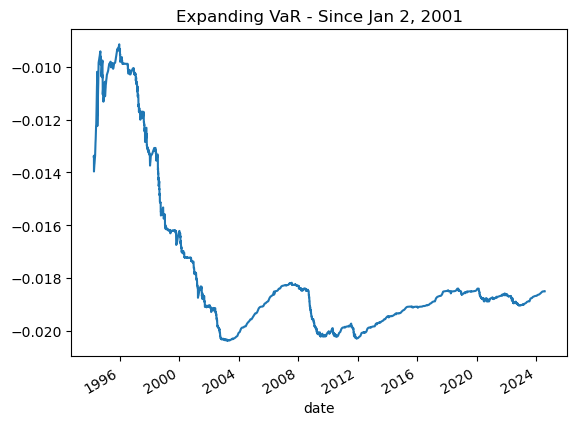

In [5]:
# We must shift the data because the VaR is for the 
spy_data["Hist_VaR"] = spy_data.shift().expanding(min_periods = 60).quantile(.05)["SPY_Excess_Return"]
spy_data["Hist_VaR"].plot(title="Expanding VaR - Since Jan 2, 2001")
spy_data = spy_data[spy_data.index >= "2001-01-02"]


In [6]:
out_var_percentage = spy_data.loc[spy_data["SPY_Excess_Return"] < spy_data["Hist_VaR"],"SPY_Excess_Return"].count()/len(spy_data["Hist_VaR"].dropna())
print(f"Using this expanding window for the Historical VaR, the returns exceeded the VaR threshold (Hit Ratio) {out_var_percentage * 100:.2f}% of the time (Hit Ratio Error {abs(out_var_percentage/0.05 -1) * 100:.2f}%).")

Using this expanding window for the Historical VaR, the returns exceeded the VaR threshold (Hit Ratio) 4.86% of the time (Hit Ratio Error 2.82%).


In this sample data, historical VaR with a 60 days expanding windows showed an overestimation of the tail risk (it should be close to 5% instead of 3.98%, hich represent an error of 20.37%). When we use a historical VaR, we relay on the number of data that we have available, therefore, if we have a small sample we could overestimate or subestimate the VaR. On the other hand, we could use a parametric VaR instead of historical, but we should make an assumption of that the returns follow a Normal Distribution.

***

## 1.2 Volatility
We will calculate a time-series of volatility estimates using a few different methods. For each, we use $\sigma_t$ to denote our estimate of the time-t return volatility.

#### Expanding Series

$$
\sigma^2_{t,expanding} = \frac{1}{t-1}\sum_{\tau = 1}^{t-1}\tilde{r}^2_{\tau}
$$



#### Rolling Window

$$
\sigma^2_{t,rolling} = \frac{1}{m}\sum_{l = 1}^{m}\tilde{r}^2_{t-l}
$$

Use $m=$`252`.


#### Exponentially Weighted Moving Average (EWMA)

Feel free to calculate the EWMA using the following recursion,
$$
\sigma^2_{t, EWMA} = \theta \sigma^2_{t-1, EWMA} + (1-\theta)\tilde{r}^2_{t-1}
$$

Rather than estimating $\theta$, simply use $\theta$ = 0.94, and initialize with 
$$\sigma_{t_0} = \frac{0.20}{\sqrt{252}}$$

### Report
Report the items below, starting at , starting at `Jan 2, 2001`.

* For each of these three methods, plot $\sigma_t$. (Plot the vol, not the variance.)

* For each method, calculate the 5th percentile, 1-day-ahead VaR. We use a slight simplification of the normal VaR formula, by dropping $\mu$ from that formula, and rounding the normal distribution z-score to -1.65.
$$\tilde{r}^{VaR, 0.05}_{t} = −1.65 \sigma_t$$

* For each of these vol-based VaR estimates, calculate the frequency of periods in which $\tilde{r} < \tilde{r}^{VaR, 0.05}_{t}$

* Compare and contrast your results among each other and relative to the historic method in the previous problem.

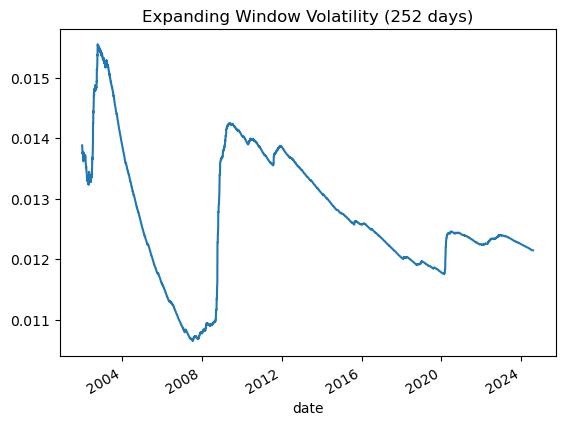

In [6]:
spy_data["Expanding_vol"] = np.sqrt((spy_data.shift()["SPY_Excess_Return"]**2).expanding(min_periods = 252).mean())
spy_data["Expanding_vol"].plot(title="Expanding Window Volatility (252 days)")
Hit_Ratio_Expanding_vol = spy_data.loc[spy_data["SPY_Excess_Return"] < spy_data["Expanding_vol"]*(-1.65),"SPY_Excess_Return"].count()/len(spy_data["Expanding_vol"].dropna())


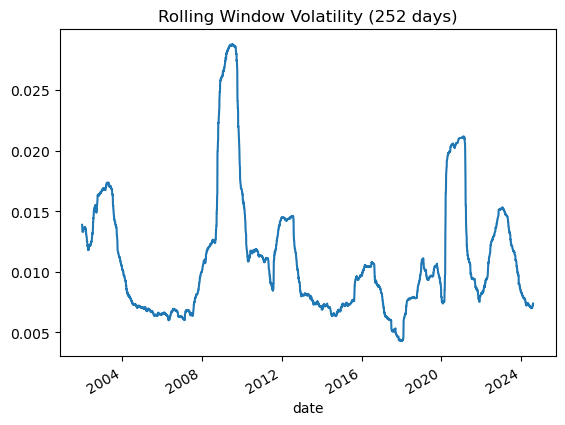

In [9]:
spy_data["Rolling_Vol"] = np.sqrt((spy_data.shift()["SPY_Excess_Return"]**2).rolling(252).mean())
spy_data["Rolling_Vol"].plot(title="Rolling Window Volatility (252 days)")
Hit_Ratio_Rolling_Vol = spy_data.loc[spy_data["SPY_Excess_Return"] < spy_data["Rolling_Vol"]*(-1.65),"SPY_Excess_Return"].count()/len(spy_data["Rolling_Vol"].dropna())


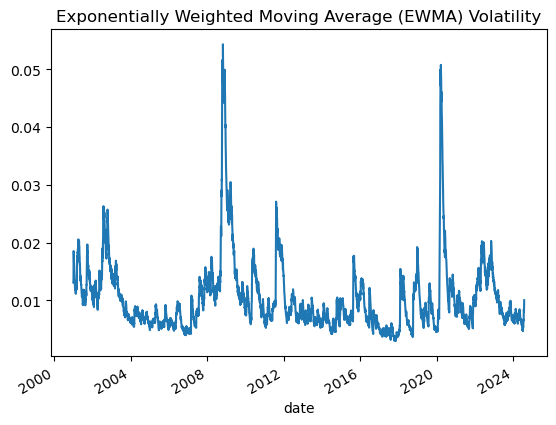

In [28]:
def ewma(returns, theta = 0.94, sigma_zero = 0.2/np.sqrt(252)):
    ewma_var = [sigma_zero**2]
    for i in range(len(returns)):
        var = ewma_var[-1]*theta + (returns.iloc[i]**2)*(1-theta)
        ewma_var.append(var)
    ewma_var = np.sqrt(ewma_var[1:])
    return ewma_var
spy_data["EWMA_Vol"] = ewma(spy_data["SPY_Excess_Return"])
spy_data["EWMA_Vol"].plot(title="Exponentially Weighted Moving Average (EWMA) Volatility")
Hit_Ratio_EWMA_Vol = spy_data.loc[spy_data["SPY_Excess_Return"] < spy_data["EWMA_Vol"]*(-1.65),"SPY_Excess_Return"].count()/len(spy_data["EWMA_Vol"].dropna())


In [82]:
print(f"Hit Ratio of the Parametric VaR: \n \nHit Ratio Expanding Vol (252d) = {Hit_Ratio_Expanding_vol* 100:.2f}% \nHit Ratio Rolling Vol (252d) = {Hit_Ratio_Rolling_Vol* 100:.2f}% \nHit Ratio EWMA Vol = {Hit_Ratio_EWMA_Vol* 100:.2f}%")
print(f"\n \nHit Ratio Error of the Parametric VaR: \n \nHit Ratio Error Expanding Vol (252d) = {abs(Hit_Ratio_Expanding_vol/0.05 -1)* 100:.2f}% \nHit Ratio Error Rolling Vol (252d) = {abs(Hit_Ratio_Rolling_Vol/0.05 -1)* 100:.2f}% \nHit Ratio Error EWMA Vol = {abs(Hit_Ratio_EWMA_Vol/0.05 -1)* 100:.2f}%")

Hit Ratio of the Parametric VaR: 
 
Hit Ratio Expanding Vol (252d) = 3.66% 
Hit Ratio Rolling Vol (252d) = 5.34% 
Hit Ratio EWMA Vol = 5.08%

 
Hit Ratio Error of the Parametric VaR: 
 
Hit Ratio Error Expanding Vol (252d) = 26.71% 
Hit Ratio Error Rolling Vol (252d) = 6.77% 
Hit Ratio Error EWMA Vol = 1.55%


* Expanding Window: This approach involves continuously adding new data to the sample, useful when you expect the data to exhibit consistent behavior over time.

* Rolling Window: This method uses a fixed number of the most recent data points, emphasizing newer information. It is suitable when you believe that recent data is more relevant, and past scenarios may not recur.

* Exponentially Weighted Moving Average (EWMA): This technique combines the benefits of the expanding and rolling windows by assigning more weight to recent data while still considering past information, capturing both recent trends and historical context.

When applying EWMA for estimating volatility in this parametric Value at Risk (VaR) model, we achieved a Hit Ratio of approximately 5.0%, with a Hit Ratio Error of 1.55%. This result outperformed other methods, including Expanding Window, Rolling Volatility, and Historical VaR.

<Axes: title={'center': 'Parametric VaR (5%)'}, xlabel='date'>

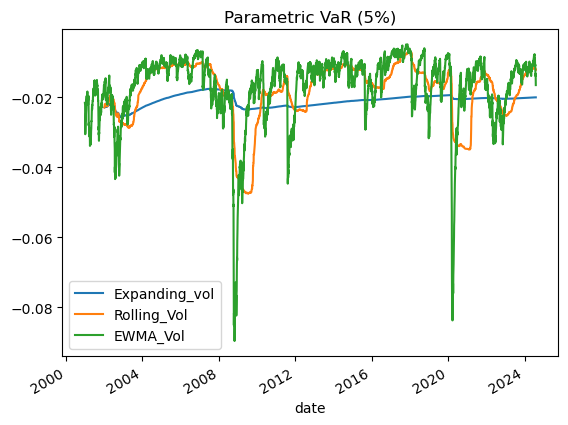

In [83]:
(spy_data[["Expanding_vol","Rolling_Vol","EWMA_Vol"]]*(-1.65)).plot(title="Parametric VaR (5%)")

***

## 1.3 CVaR
Re-do the previous two problems, but this time calculating CVaR instead of VaR, (still for $q =$ `.05`.) 

<Axes: title={'center': 'CVaR (5%) - Historical & Empirical'}, xlabel='date'>

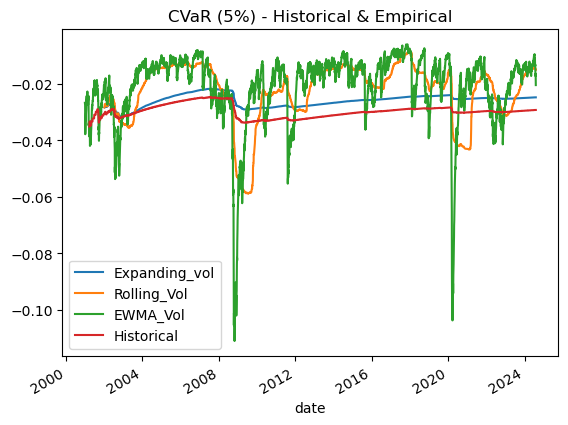

In [93]:
CVaR = (spy_data[["Expanding_vol","Rolling_Vol","EWMA_Vol"]]*(-norm.pdf(1.65)/0.05))
CVaR["Historical"] = spy_data["SPY_Excess_Return"].expanding(60).apply(lambda x: x[x < x.quantile(.05)].mean())
CVaR.plot(title = "CVaR (5%) - Historical & Empirical")

***

## 1.4 GARCH

#### EXTRA: Not Submitted, not covered in Midterm 1

Re-do the VaR and CVaR calculations using a normal model with volatility calculated from a GARCH(1,1).

To estimate GARCH(1,1), try using the ARCH package in Python. The default estimation implementation is fine. You should be familiar with EWMA and GARCH from the August Review.